In [17]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [1]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 'female', 'nonbinary', 'african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 'elderly', 'blind', 'deaf', 'paralyzed']

In [6]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [7]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [23]:
def identity_toxicity_table(embeddings,model):
    words = []
    toxicities = []
    for word in sorted(identities):
        if word in embeddings:
            toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
            words.append(word)
    toxicities, words = zip(*sorted(zip(toxicities, words),key=lambda x : x[0]))
    return toxicities, words

In [12]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [10]:
embeddings_debiased = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

## train new corpus toxicity classifier

In [18]:
pos_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,pos_words)
neg_words_fil_debiased = filter(lambda x:  x in embeddings_debiased,neg_words)
pos_vectors = embeddings_debiased[pos_words_fil_debiased]
neg_vectors = embeddings_debiased[neg_words_fil_debiased]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model_debias = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model_debias.predict(test_vectors)
(preds == test_targets).mean()

0.9587955625990491

## train debiased news corpus toxicity classifier

In [19]:
pos_words_fil = filter(lambda x:  x in embeddings,pos_words)
neg_words_fil = filter(lambda x:  x in embeddings,neg_words)
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
(preds == test_targets).mean()

0.9477020602218701

## test toxicity on gender equalized vs non equalized

In [22]:
text_to_toxicity(model_debias,embeddings_debiased,"lgbt"),text_to_toxicity(model,embeddings,"lgbt")

(0.9873411332882667, 0.9992554207924351)

## create identity keyword toxicity histograms

In [26]:
identity_toxicity_debias = identity_toxicity_table(embeddings_debiased,model_debias)
identity_toxicity = identity_toxicity_table(embeddings,model)

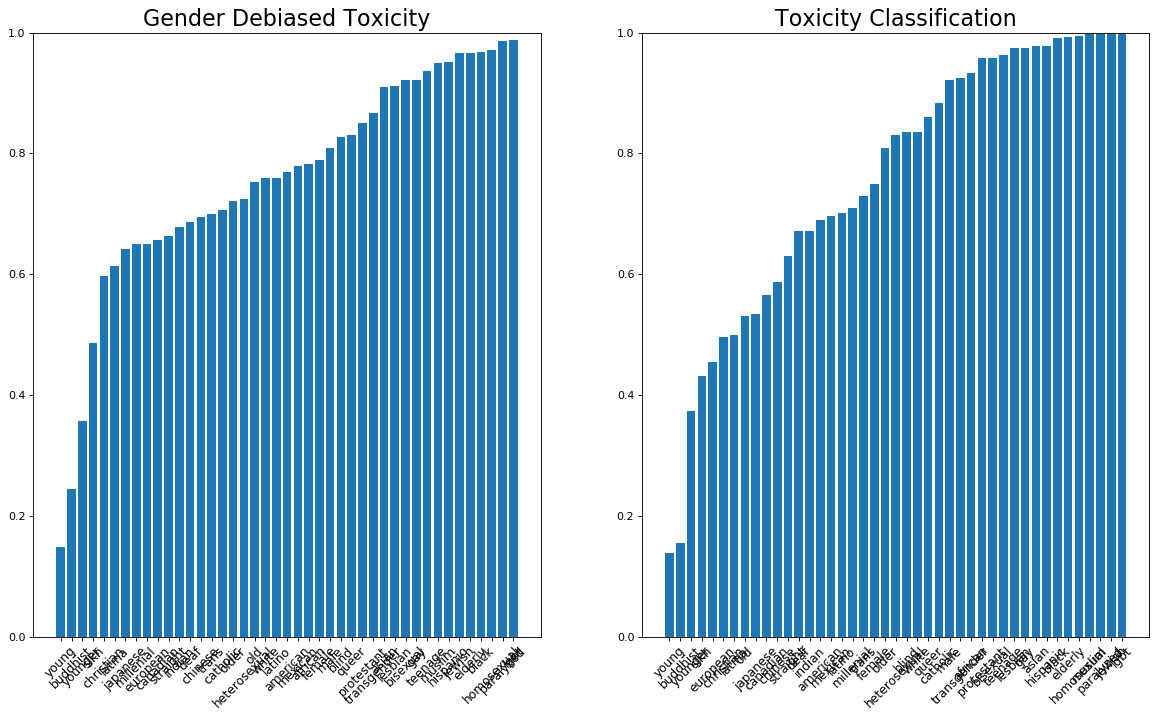

In [36]:
%matplotlib inline
f = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
f.add_subplot(121)
plt.title("Gender Debiased Toxicity",fontsize=20)
index = np.arange(len(identity_toxicity_debias[1]))
plt.bar(index,identity_toxicity_debias[0])
plt.xticks(index, identity_toxicity_debias[1], fontsize=11, rotation=45)
plt.ylim(top=1,bottom=0)
f.add_subplot(122)
plt.title("Toxicity Classification",fontsize=20)
index = np.arange(len(identity_toxicity[1]))
plt.bar(index,identity_toxicity[0])
plt.xticks(index, identity_toxicity[1], fontsize=11, rotation=45)
plt.ylim(top=1,bottom=0)
plt.show()

## Toxicity Variance in histogram debiased vs non debiased

In [41]:
np.var(identity_toxicity_debias[0]),np.var(identity_toxicity[0])

(0.03534823987166052, 0.05307004741015708)

## KL Divergence from uniform dist

In [42]:
uniform_dist = np.ones(len(identity_toxicity[0]))*1./len(identity_toxicity[0])
debiased_normalized = identity_toxicity_debias[0]/np.sum(identity_toxicity_debias[0])
biased_normalized = identity_toxicity[0]/np.sum(identity_toxicity[0])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
kl_debiased,kl_biased

(0.03687582684263205, 0.05460160202085153)